# Custom BlockTimeSeriesSplit Class for K-Fold Validation of Time Series

**BOOKMARKS:**
- [Defining Class BlockTimeSeriesSplit](#def-BlockTimeSeriesSplit)
- [Using BlockTimeSeriesSplit](#Using-`BlockTimeSeriesSplit`)

In [1]:
## IMPORT CUSTOM CAPSTONE FUNCTIONS
import functions_combined_BEST as ji

from functions_combined_BEST import ihelp, ihelp_menu,\
reload, inspect_variables

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ## IMPORT MY PUBLISHED PYPI PACKAGE 
# import bs_ds as  bs
# from bs_ds.imports import *

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

#Set pd.set_options for tweet visibility
pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_columns',50)

bs_ds  v0.9.10 loaded.  Read the docs: https://bs-ds.readthedocs.io/en/latest/index.html
For convenient loading of standard modules use: from bs_ds.imports import *



## def BlockTimeSeriesSplit

In [2]:
from sklearn.model_selection._split import _BaseKFold

class BlockTimeSeriesSplit(_BaseKFold): #sklearn.model_selection.TimeSeriesSplit):
    """A variant of sklearn.model_selection.TimeSeriesSplit that keeps train_size and test_size
    constant across folds. 
    Requires n_splits,train_size,test_size. train_size/test_size can be integer indices or float ratios """
    def __init__(self, n_splits=5,train_size=None, test_size=None, step_size=None, method='sliding'):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.train_size = train_size
        self.test_size = test_size
        self.step_size = step_size
        if 'sliding' in method or 'normal' in method:
            self.method = method
        else:
            raise  Exception("Method may only be 'normal' or 'sliding'")
        
    def split(self,X,y=None, groups=None):
        import math 
        method = self.method
        ## Get n_samples, trian_size, test_size, step_size
        n_samples = len(X)
        test_size = self.test_size
        train_size =self.train_size
      
                
        ## If train size and test sze are ratios, calculate number of indices
        if train_size<1.0:
            train_size = math.floor(n_samples*train_size)
        
        if test_size <1.0:
            test_size = math.floor(n_samples*test_size)
            
        ## Save the sizes (all in integer form)
        self._train_size = train_size
        self._test_size = test_size
        
        ## calcualte and save k_fold_size        
        k_fold_size = self._test_size + self._train_size
        self._k_fold_size = k_fold_size    
        

    
        indices = np.arange(n_samples)
        
        ## Verify there is enough data to have non-overlapping k_folds
        if method=='normal':
            import warnings
            if n_samples // self._k_fold_size <self.n_splits:
                warnings.warn('The train and test sizes are too big for n_splits using method="normal"\n\
                switching to method="sliding"')
                method='sliding'
                self.method='sliding'
                              
                  
            
        if method=='normal':

            margin = 0
            for i in range(self.n_splits):

                start = i * k_fold_size
                stop = start+k_fold_size

                ## change mid to match my own needs
                mid = int(start+self._train_size)
                yield indices[start: mid], indices[mid + margin: stop]
        

        elif method=='sliding':
            
            step_size = self.step_size
            if step_size is None: ## if no step_size, calculate one
                ## DETERMINE STEP_SIZE
                last_possible_start = n_samples-self._k_fold_size #index[-1]-k_fold_size)\
                step_range =  range(last_possible_start)
                step_size = len(step_range)//self.n_splits
            self._step_size = step_size
                
            
            for i in range(self.n_splits):
                if i==0:
                    start = 0
                else:
                    start = prior_start+self._step_size #(i * step_size)

                stop =  start+k_fold_size            
                ## change mid to match my own needs
                mid = int(start+self._train_size)
                prior_start = start
                yield indices[start: mid], indices[mid: stop]


# Load/process test data

In [3]:
df_combined = pd.read_csv('data/__combined_stock_data_with_tweet_preds.csv', index_col=0,parse_dates=True)
model_col_list = ['price','price_shifted', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band','lower_band', 'ema', 'momentum',
                  'has_tweets','num_tweets','case_ratio', 'compound_score','pos','neu','neg','sentiment_class',
                  'pred_classes','pred_classes_int','total_favorite_count','total_retweet_count']

df_combined = ji.set_timeindex_freq(df_combined,fill_nulls=False)
df_combined.sort_index(inplace=True, ascending=True)
df_combined['price_shifted'] =df_combined['price'].shift(-1)

df_to_model = df_combined[model_col_list].copy()
del df_combined
# df_to_model.head()

Index When:	Freq:	Index Start		Index End:
Pre-Change	None	2016-12-29 15:30:00	2019-08-23 15:30:00
[i] Post-Change	<CustomBusinessHour: CBH=09:30-16:30>	2016-12-29 15:30:00	2019-08-23 15:30:00

[i] Filled 0# of rows using method ffill
Cols with Nulls:
source                    3500
is_retweet                3509
id_str                    3500
tweet_times               3500
group_content             3500
content_cleaned           3506
content_min_clean         3506
content_cleaned_stop      3521
cleaned_stopped_lemmas    3521
dtype: int64


,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,date_time.1,int_tweets_for_stocks,int_bins,stock_times,source,is_retweet,id_str,tweet_times,num_tweets,total_retweet_count,total_favorite_count,group_content,has_tweets,has_stocks,has_both,has_RT,starts_RT,content_starts_RT,content_cleaned,content_min_clean,case_ratio,content_hashtags,hashtag_strings,content_mentions,mention_strings,content_cleaned_stop,content_cleaned_stop_tokens,cleaned_stopped_lemmas,sentiment_scores,compound_score,sentiment_class,neg,neu,pos,pred_classes_int,pred_classes,filled_timebin
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-29 15:30:00,96.27,96.864898,96.277007,96.573856,96.730494,0.156639,1.002051,98.281110,94.272904,96.263988,89.27,2016-12-29 15:30:00,"(2016-12-29 14:30:00, 2016-12-29 15:30:00]",5,2016-12-29 15:30:00,Twitter for iPhone,False,814484710025994241,2016-12-29 14:54:21,1.0,11330.0,45609.0,My Administration will follow two simple rules: https://t.co/ZWk0j4H8Qy,1,True,True,False,False,[],My Administration will follow two simple rules:,my administration will follow two simple rules,0.04167,[],,[],,administration follow two simple rules,"['administration', 'follow', 'two', 'simple', 'rules']",administration follow two simple rule,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.0,2,0.0,1.0,0.0,0,neg,False
2016-12-30 09:30:00,96.38,96.850204,96.293537,96.571218,96.721997,0.150779,0.980655,98.254848,94.332227,96.341329,89.38,2016-12-30 09:30:00,"(2016-12-30 08:30:00, 2016-12-30 09:30:00]",23,2016-12-30 09:30:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,True,False,False,False,[],NaN,NaN,0.00000,[],,[],,NaN,[],NaN,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}",0.0,1,0.0,0.0,0.0,1,no_change,False
2016-12-30 10:30:00,96.21,96.831633,96.307891,96.566317,96.709593,0.143275,0.959724,98.227340,94.388442,96.253776,89.21,2016-12-30 10:30:00,"(2016-12-30 09:30:00, 2016-12-30 10:30:00]",24,2016-12-30 10:30:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,True,False,False,False,[],NaN,NaN,0.00000,[],,[],,NaN,[],NaN,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}",0.0,1,0.0,0.0,0.0,1,no_change,False
2016-12-30 11:30:00,96.34,96.814286,96.322653,96.563255,96.700645,0.137390,0.938272,98.199196,94.446110,96.311259,89.34,2016-12-30 11:30:00,"(2016-12-30 10:30:00, 2016-12-30 11:30:00]",25,2016-12-30 11:30:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,True,False,False,False,[],NaN,NaN,0.00000,[],,[],,NaN,[],NaN,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}",0.0,1,0.0,0.0,0.0,1,no_change,False
2016-12-30 12:30:00,96.25,96.794694,96.336531,96.559027,96.689742,0.130715,0.912397,98.161325,94.511736,96.270420,89.25,2016-12-30 12:30:00,"(2016-12-30 11:30:00, 2016-12-30 12:30:00]",26,2016-12-30 12:30:00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,True,False,False,False,[],NaN,NaN,0.00000,[],,[],,NaN,[],NaN,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}",0.0,1,0.0,0.0,0.0,1,no_change,False


### Using Pipeline to Prepare Data for Modeling

- Note: this section was me learning to using Pipelines and ColumnTransformer. It is used for processing the data but is NOT meant to be an example. 

In [4]:
## Using ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit,train_test_split, GridSearchCV,cross_val_score,KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


import xgboost as xgb
target_col= 'price_shifted'
## Sort_index
cols_to_drop =['price','pred_classes_int']
cols_to_drop.append(target_col)

features = df_to_model.drop(cols_to_drop, axis=1)
target = df_to_model[target_col]

## Get boolean masks for which columns to use
numeric_cols = features.dtypes=='float'
category_cols = ~numeric_cols
# target_col = df_to_model.columns=='price_shifted'

price_transformer = Pipeline(steps=[
    ('scaler',MinMaxScaler())
])

## define pipeline for preparing numeric data
numeric_transformer = Pipeline(steps=[
#     ('imputer',SimpleImputer(strategy='median')),
    ('scaler',MinMaxScaler())
])

category_transformer = Pipeline(steps=[
#     ('imputer',SimpleImputer(missing_values=np.nan,
#                              strategy='constant',fill_value='missing')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])


## define pipeline for preparing categorical data
preprocessor = ColumnTransformer(remainder='passthrough',
                                 transformers=[
                                     ('num',numeric_transformer, numeric_cols),
                                     ('cat',category_transformer,category_cols)])

In [5]:
### ADDING MY OWN TRANSFORMATION SO CAN USE FEATURE IMPROTANCE
df_tf =pd.DataFrame()

## Define Number vs Category Cols
num_cols_list = numeric_cols[numeric_cols==True]
cat_cols_list = category_cols[category_cols==True]

for col in df_to_model.columns:
    
    if col in num_cols_list:
#         print(f'{col} is numeric')
        vals = df_to_model[col].values
        tf_num = numeric_transformer.fit_transform(vals.reshape(-1,1))
        
        try:
            df_tf[col] = tf_num.flatten()
#             print(f"{col} added")
        except:
            continue
#             print(f'Error flattening {col}, shape={tf_num.shape}')
#             print(tf_num.shape)
#             print(tf_num[:10])
        
    if col in cat_cols_list:
#         print(f'{col} is categorical')
        df_temp = pd.get_dummies(df_to_model[col])#DataFrame(data=tf_cats[:],index=df_to_model.index)
        df_tf = pd.concat([df_tf,df_temp],axis=1)

df_tf.head()

,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,0,1,0,1,2,neg,no_change,pos
0,0.018791,0.000000,0.003526,0.010402,0.686492,0.141494,0.033515,0.036878,0.073543,0.083656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.018152,0.000739,0.003403,0.010025,0.685331,0.136876,0.032455,0.039368,0.076574,0.087916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.017344,0.001380,0.003176,0.009475,0.683844,0.132358,0.031345,0.041728,0.073142,0.081332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.016590,0.002040,0.003035,0.009078,0.682678,0.127728,0.030208,0.044149,0.075395,0.086367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.015738,0.002660,0.002839,0.008594,0.681355,0.122143,0.028679,0.046905,0.073795,0.082881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Using `BlockTimeSeriesSplit`

In [6]:
## BlockTimeSeriesSplit 
split_ts = BlockTimeSeriesSplit(n_splits = 5, train_size=0.3,test_size=0.1,method='sliding')#train_size=840, test_size=10*7)
master_date_index=df_to_model.index.to_series()

n=0
dashes = '---'*20
for train_index, test_index in split_ts.split(df_to_model):  
    
    print(f'\n{dashes}\nsplit {n}')
    train_date_index = master_date_index.iloc[train_index]
    test_date_index = master_date_index.iloc[test_index]
    ji.index_report(train_date_index)
    ji.index_report(test_date_index)
    n+=1


------------------------------------------------------------
split 0
------------------------------------------------------------
	INDEX REPORT:	
------------------------------------------------------------
* Index Endpoints:
	2016-12-29 15:30:00 -- to -- 2017-10-17 09:30:00
* Index Freq:
	<CustomBusinessHour: CBH=09:30-16:30>
------------------------------------------------------------
	INDEX REPORT:	
------------------------------------------------------------
* Index Endpoints:
	2017-10-17 10:30:00 -- to -- 2018-01-22 09:30:00
* Index Freq:
	<CustomBusinessHour: CBH=09:30-16:30>

------------------------------------------------------------
split 1
------------------------------------------------------------
	INDEX REPORT:	
------------------------------------------------------------
* Index Endpoints:
	2017-04-25 14:30:00 -- to -- 2018-02-08 15:30:00
* Index Freq:
	<CustomBusinessHour: CBH=09:30-16:30>
------------------------------------------------------------
	INDEX REPORT:	
---

In [7]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
from xgboost import plot_importance,plot_tree
reg= xgb.XGBRegressor(random_state=42, n_estimators=500)

# split_ts = TimeSeriesSplit(n_splits=5)#,max_train_size=7*5*6)
split_ts = BlockTimeSeriesSplit(n_splits=5,train_size=0.3,test_size=0.1,method='normal')#train_size=7*5*4*3, test_size = 7*10)

results_list=[]
k=0
date_index = features.index.to_series()

for train_index, test_index in split_ts.split(features):  
    
    df_train = features.iloc[train_index]
    df_test = features.iloc[test_index]
    
    y_train = target.iloc[train_index].values
    y_test = target.iloc[test_index].values
    
    train_date_index = date_index.iloc[train_index]
    test_date_index = date_index.iloc[test_index]
    
    ## Fitting preprocessor to training data, transforming both
    preprocessor.fit(features)
    X_train = preprocessor.transform(df_train)
    X_test = preprocessor.transform(df_test)
    
   
        
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    
    
    
    true_train_series = pd.Series(y_train, index=train_date_index,name='true_train_price')
    true_test_series = pd.Series(y_test, index=test_date_index,name='true_test_price')
    pred_price_series = pd.Series(pred,index=test_date_index,name='pred_test_price')#.plot()
    
    df_xgb = pd.concat([true_train_series,true_test_series,pred_price_series],axis=1)


    try:
    
        df_results = ji.evaluate_regression(true_test_series,pred_price_series,show_results=False);
    
    except:
        print(f"Trouble with k={k}")      
    finally:

        fold_dict = {'k':k,
                     'train_index':train_date_index,
                     'test_index':test_date_index,
                     'results':df_results,
                     'df_model':df_xgb,
                     'model':reg}
        results_list.append(fold_dict)
        k+=1    

## Visualizing Train/Test Splits and Predictions

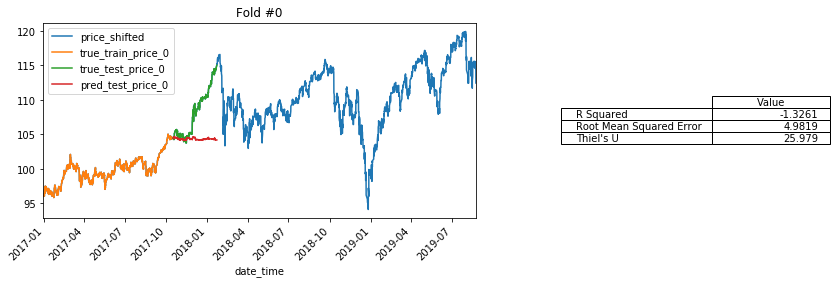

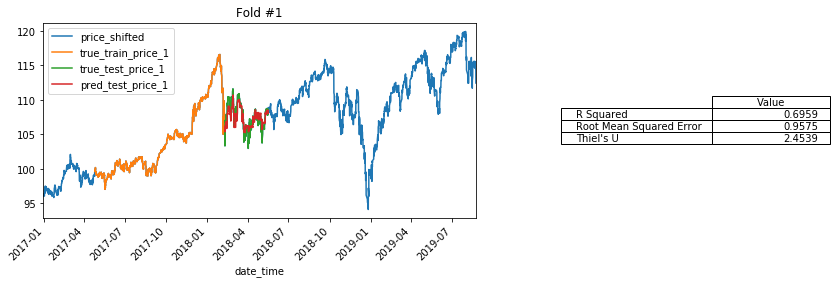

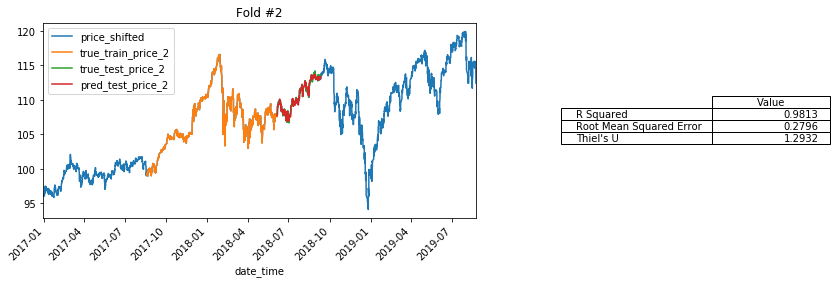

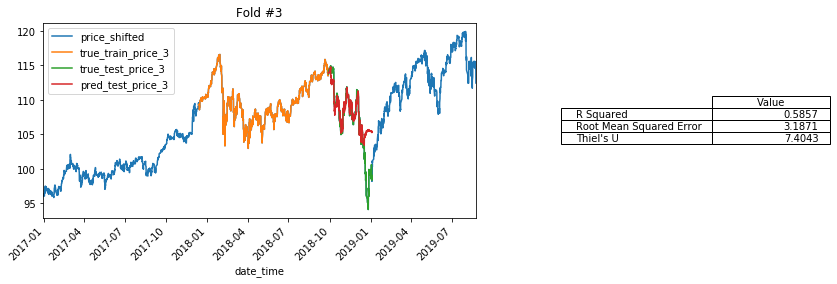

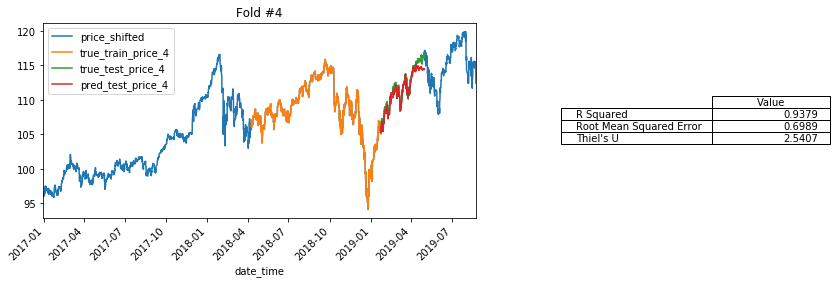

In [8]:
from pandas import plotting
## PLOT ALL TRAIN/TEST SAMPLES ON ONE PLT
for i in range(len(results_list)):
    
    ## get results items 
    k = results_list[i]['k']
    df_model = results_list[i]['df_model'].copy()#
    df_results = results_list[i]['results']

    ## rename columns to identify on same plot
    new_colnames = df_model.columns+f"_{k}"
    df_model.columns  = new_colnames
    
    ## add to df_ind_plots and plot
    df_ind_plots = pd.concat([target.copy(),df_model],axis=1) # reset each time
    

    ## Create fig, axes     #     display(df_results.style.set_caption(f'Fold#{i}'))
    ax1= plt.subplot2grid((1,3),(0,0), colspan=2)
    ax2 =plt.subplot2grid((1,3),(0,2), colspan=1)
    ax2.axis('off')
    fig = plt.gcf()
    
    # Plot data
    df_ind_plots.plot(title=f'Fold #{k}',rot=45,figsize=(12,4),ax=ax1) #table=df_results) 
    # Plot results table
    plotting.table(ax2, colWidths=[0.6, 0.2],data=df_results,loc='right')
    plt.show()   